# LDDMM: parallel transport

Imagine we are given three meshes A, B, C.

In this notebook we will:

* register A to B (fixed), and C to B (fixed)

* parallel transport BC along BA


(Check the last section to understand how to use `parallel_transport_ABC` with a simple API. This function does all the steps that are presented along this notebook.)

In [1]:
import shutil
from pathlib import Path

import pyvista as pv

import polpo.lddmm as plddmm
import polpo.preprocessing.dict as ppdict
from polpo.plot.pyvista import RegisteredMeshesGifPlotter
from polpo.preprocessing.load.deformetrica import (
    LoadControlPointsFlow,
    LoadMeshFlow,
    LoadMomentaFlow,
)
from polpo.preprocessing.load.pregnancy.jacobs import MeshLoader
from polpo.preprocessing.mesh.io import DictMeshWriter
from polpo.preprocessing.mesh.registration import RigidAlignment
from polpo.preprocessing.str import Contains

W0929 16:06:41.839000 224645 site-packages/torch/utils/cpp_extension.py:118] No CUDA runtime is found, using CUDA_HOME='/usr'


In [2]:
RECOMPUTE = True  # in case registrations have already been run
STATIC_VIZ = True

if STATIC_VIZ:
    pv.set_jupyter_backend("static")

In [3]:
OUTPUTS_DIR = Path("results") / "transport_abc"

if OUTPUTS_DIR.exists() and RECOMPUTE:
    shutil.rmtree(OUTPUTS_DIR)

## Loading meshes

In [4]:
struct_subset = ["L_Hipp"]

dict_to_vals = ppdict.ExtractUniqueKey(nested=True) + ppdict.DictToValuesList()

In [5]:
path2mesh_01 = MeshLoader(
    subject_subset=["01"],
    session_subset=[1, 26],
    struct_subset=["L_Hipp"],
    as_mesh=True,
)

path2mesh_1001B = MeshLoader(
    subject_subset=["1001B"],
    session_subset=["base1"],
    struct_subset=["L_Hipp"],
    as_mesh=True,
)

A = (path2mesh_1001B + ppdict.ExtractUniqueKey(nested=True))()
B, C = (path2mesh_01 + dict_to_vals)()

meshes = [A, B, C]

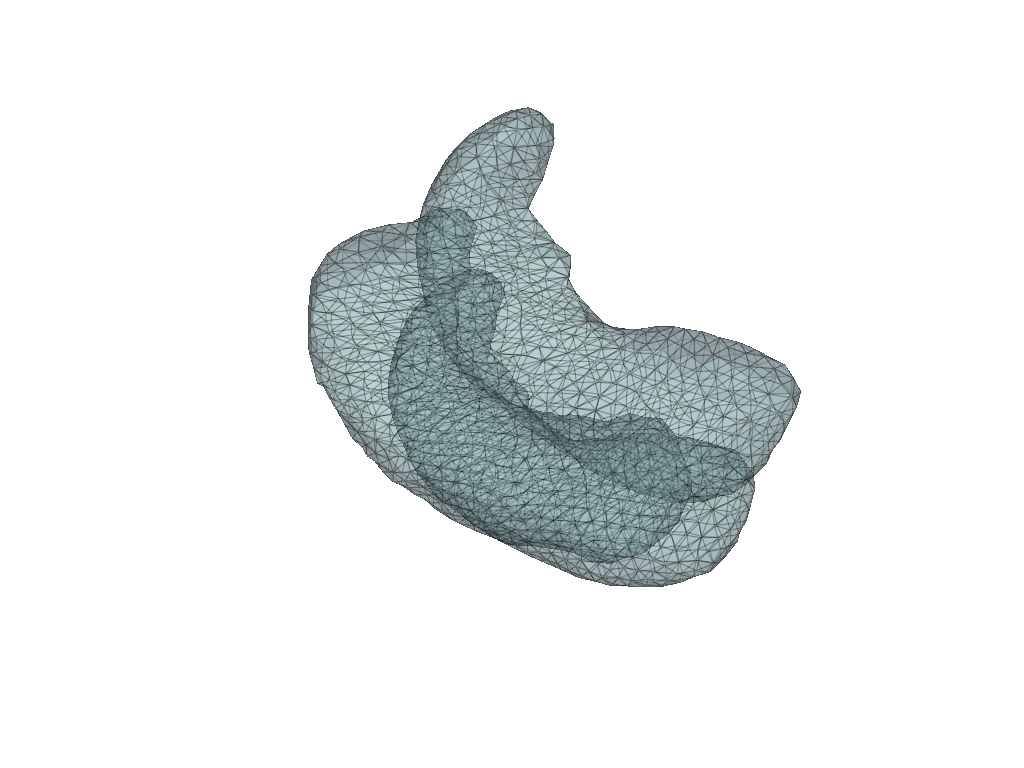

In [6]:
pl = pv.Plotter(border=False)

for mesh in meshes:
    pl.add_mesh(mesh, show_edges=True, opacity=0.5)

pl.show()

In [7]:
prep_pipe = RigidAlignment(max_iterations=500)

meshes = prep_pipe(meshes)

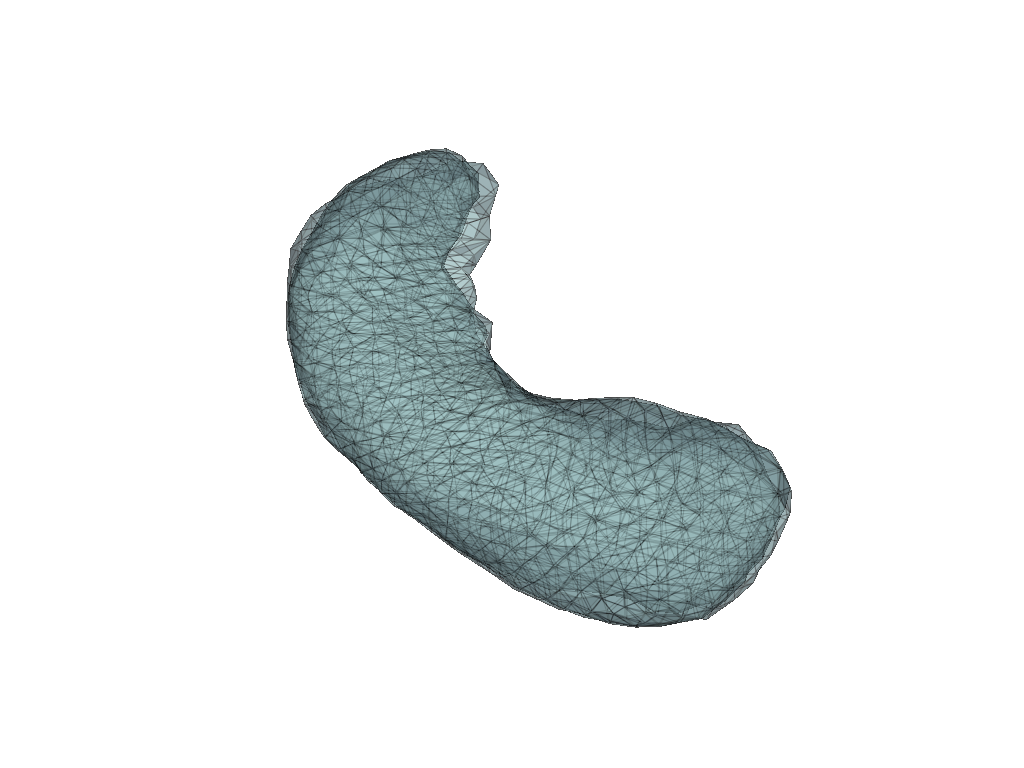

In [8]:
pl = pv.Plotter(border=False)

for mesh in meshes:
    pl.add_mesh(mesh, show_edges=True, opacity=0.5)

pl.show()

## Registrations

Closely following [LDDMM: how to register a mesh to a template?](./lddmm_register_mesh_template.ipynb), we register A to B and C to B.

In [9]:
meshes_writer = DictMeshWriter(dirname=OUTPUTS_DIR, ext="vtk")

# index: path
dataset = meshes_writer({index: mesh for index, mesh in zip(("A", "B", "C"), meshes)})

In [10]:
def _register_dir_from_pair(source, target):
    return OUTPUTS_DIR / f"{source}->{target}"


pairs = (("B", "A"), ("B", "C"))

kernel_width = 10.0
registration_kwargs = dict(
    kernel_width=kernel_width,
    regularisation=1.0,
    max_iter=2000,
    freeze_control_points=False,
    metric="varifold",
    tol=1e-16,
    attachment_kernel_width=2.0,
)

for source, target in pairs:
    if _register_dir_from_pair(source, target).exists():
        continue

    plddmm.registration.estimate_registration(
        source=dataset[source],
        target=dataset[target],
        output_dir=_register_dir_from_pair(source, target),
        **registration_kwargs,
    )

Logger has been set to: DEBUG
>> No initial CP spacing given: using diffeo kernel width of 10.0
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 10
context has already been set
>> No specified state-file. By default, Deformetrica state will by saved in file: results/transport_abc/B->A/deformetrica-state.p.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
instantiating kernel torch with kernel_width 10.0 and gpu_mode GpuMode.KERNEL. addr: 0x7c772b2e32f0
instantiating kernel torch with kernel_width 2.0 and gpu_mode GpuMode.KERNEL. addr: 0x7c772b31c2c0
>> Set of 24 control points defined.
>> Momenta initialized to zero, for 1 subjects.
dtype=float32
>> Started estimator: ScipyOptimize

>> Scipy optimization method: L-BFGS-B

------------------------------------- Iteration: 1 -------------------------------------

--------------

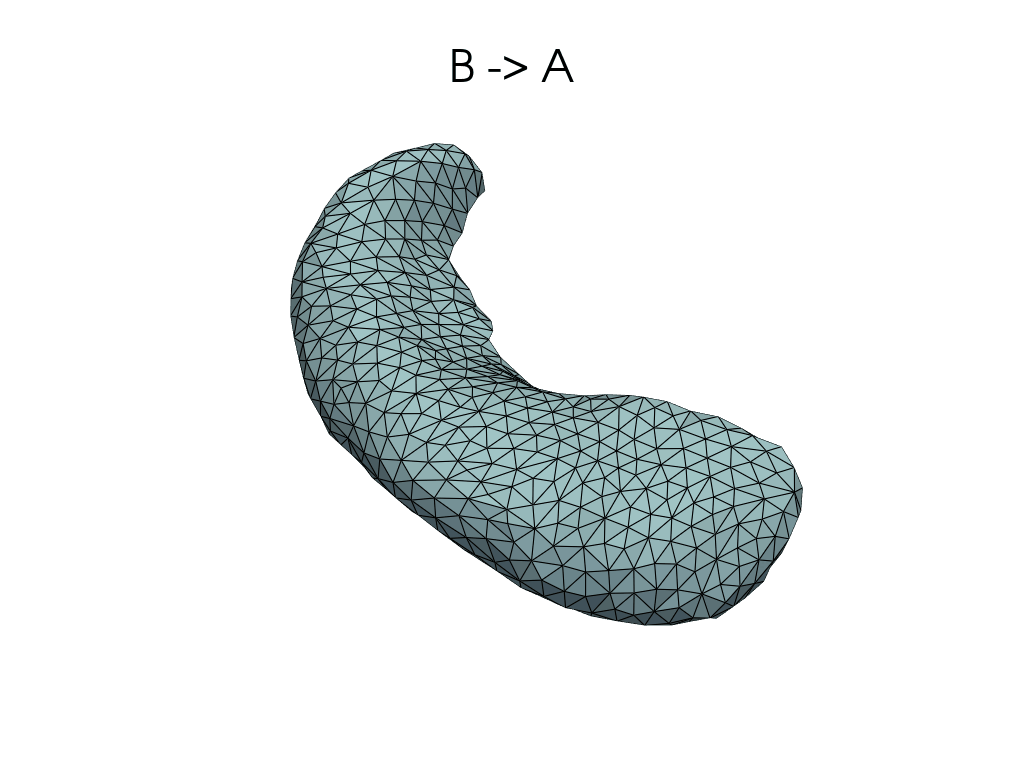

In [11]:
source, target = pairs[0]

flow_meshes = plddmm.io.load_deterministic_atlas_flow(
    _register_dir_from_pair(source, target),
    as_pv=True,
)


pl = RegisteredMeshesGifPlotter()
pl.add_title(f"{source} -> {target}")

pl.add_meshes(flow_meshes)
pl.close()

pl.show()

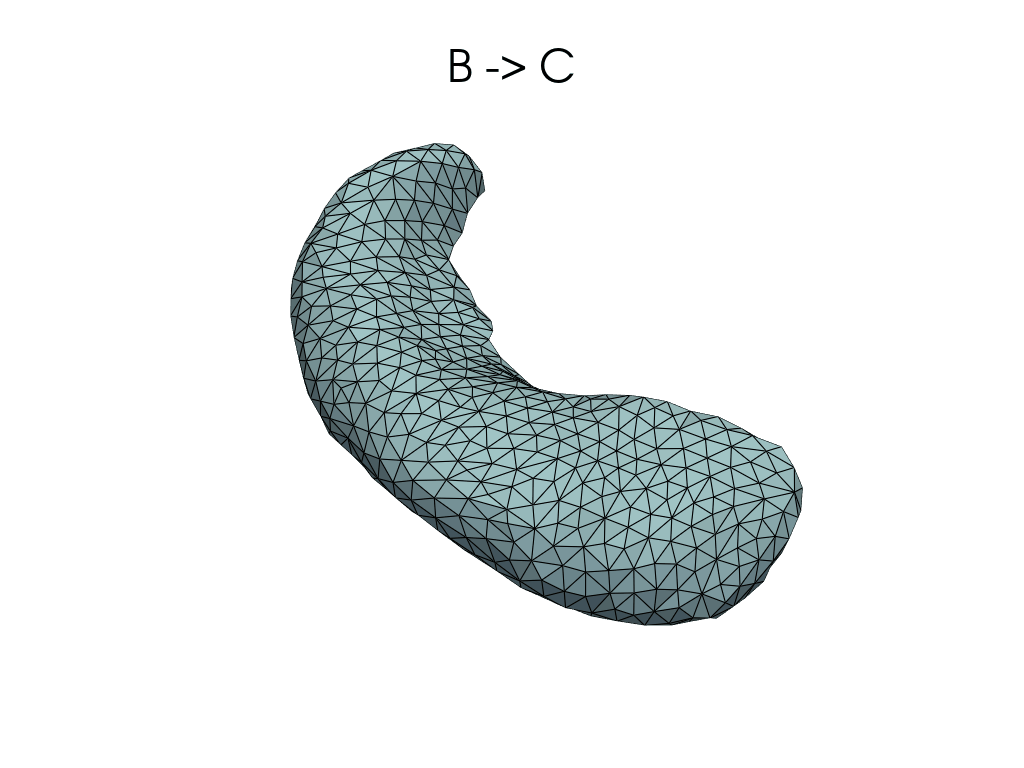

In [12]:
source, target = pairs[1]

flow_meshes = plddmm.io.load_deterministic_atlas_flow(
    _register_dir_from_pair(source, target),
    as_pv=True,
)

pl = RegisteredMeshesGifPlotter()
pl.add_title(f"{source} -> {target}")

pl.add_meshes(flow_meshes)
pl.close()

pl.show()

## Parallel transport

Let's parallel transport BC along B -> A.

(See [LDDMM: parallel transporting face motion](./lddmm_shape_geodesic.ipynb) for details.)

In [13]:
source = "B"
geod_target = "A"
transp_target = "C"

transport_output_dir = (
    OUTPUTS_DIR / f"{source}{transp_target}--{source}{geod_target}>{geod_target}"
)

if not transport_output_dir.exists():
    plddmm.geometry.parallel_transport(
        source=dataset[source],
        control_points=plddmm.io.load_cp(
            _register_dir_from_pair(source, geod_target), as_path=True
        ),
        momenta=plddmm.io.load_momenta(
            _register_dir_from_pair(source, geod_target), as_path=True
        ),
        control_points_to_transport=plddmm.io.load_cp(
            _register_dir_from_pair(source, transp_target), as_path=True
        ),
        momenta_to_transport=plddmm.io.load_momenta(
            _register_dir_from_pair(source, transp_target), as_path=True
        ),
        kernel_width=kernel_width,
        output_dir=transport_output_dir,
    )

/home/luisfpereira/miniconda3/envs/deformetrica/lib/python3.12/site-packages/launch/compute_parallel_transport.py:92: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH
This transform will produce equivalent results for all valid (symmetric positive definite) inputs. (Triggered internally at /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1765.)
  cholesky_kernel_matrix = torch.cholesky(kernel_matrix)
/home/luisfpereira/miniconda3/envs/deformetrica/lib/python3.12/site-packages/in_out/dataset_functions.py:265: UserWarning: Watch out, I did not get a distance type for the object shape, Please make sure you are running shooting or a parallel transport, otherwise distances are required.
  warnings.warn(msg)


time taken to compute parallel_transport: 0.009394772991072387


Let's visualize the parallel curve.

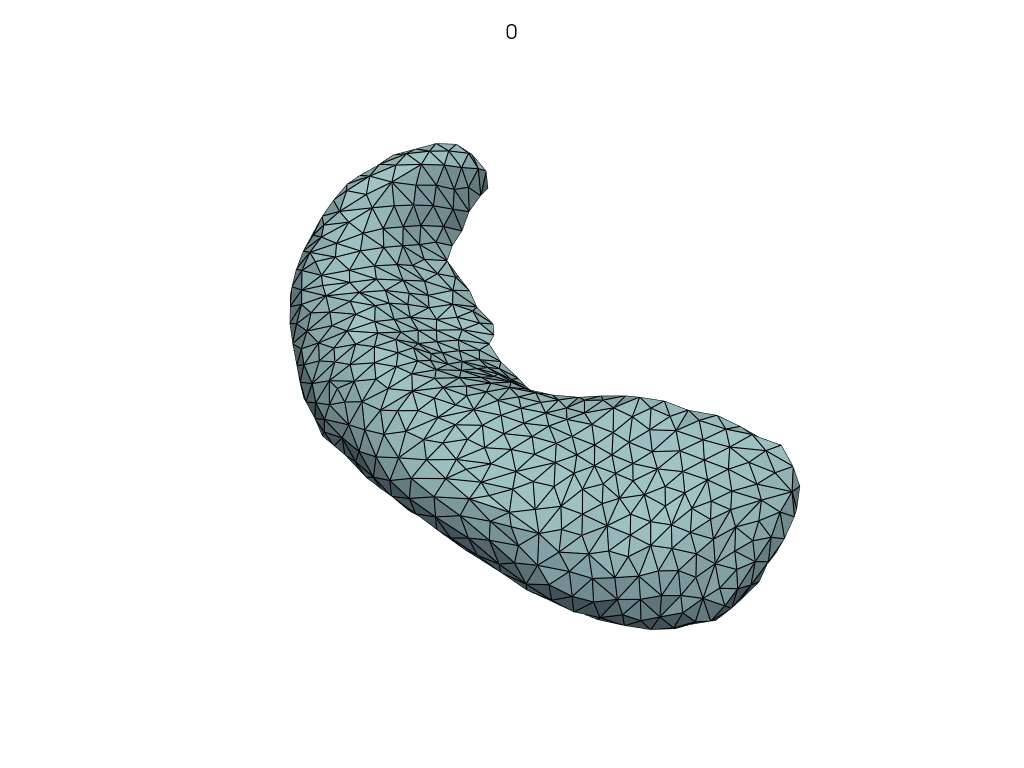

In [14]:
parallel_meshes = LoadMeshFlow(
    as_path=False,
    extra_rules=Contains("parallel_curve"),
)(transport_output_dir)


pl = RegisteredMeshesGifPlotter(
    subtitle=lambda x, y: str(x),
    fps=10,
)

pl.add_meshes(parallel_meshes)
pl.close()

pl.show()

Let's shoot from A.



In [15]:
select_last = ppdict.DictToValuesList() + (lambda x: x.pop())

shoot_dir = OUTPUTS_DIR / f"{geod_target}(t{source}{transp_target})"

if not shoot_dir.exists():
    plddmm.geometry.shoot(
        source=dataset[geod_target],
        control_points=(LoadControlPointsFlow(as_path=True) + select_last)(
            transport_output_dir
        ),
        momenta=(LoadMomentaFlow(as_path=True) + select_last)(transport_output_dir),
        kernel_width=kernel_width,
        concentration_of_time_points=10,
        kernel_type="torch",
        output_dir=shoot_dir,
        write_adjoint_parameters=False,
    )

[ compute_shooting function ]
Defaulting geodesic t0 to 1.
Defaulting geodesic tmax to 1.
Defaulting geodesic tmin to 0.


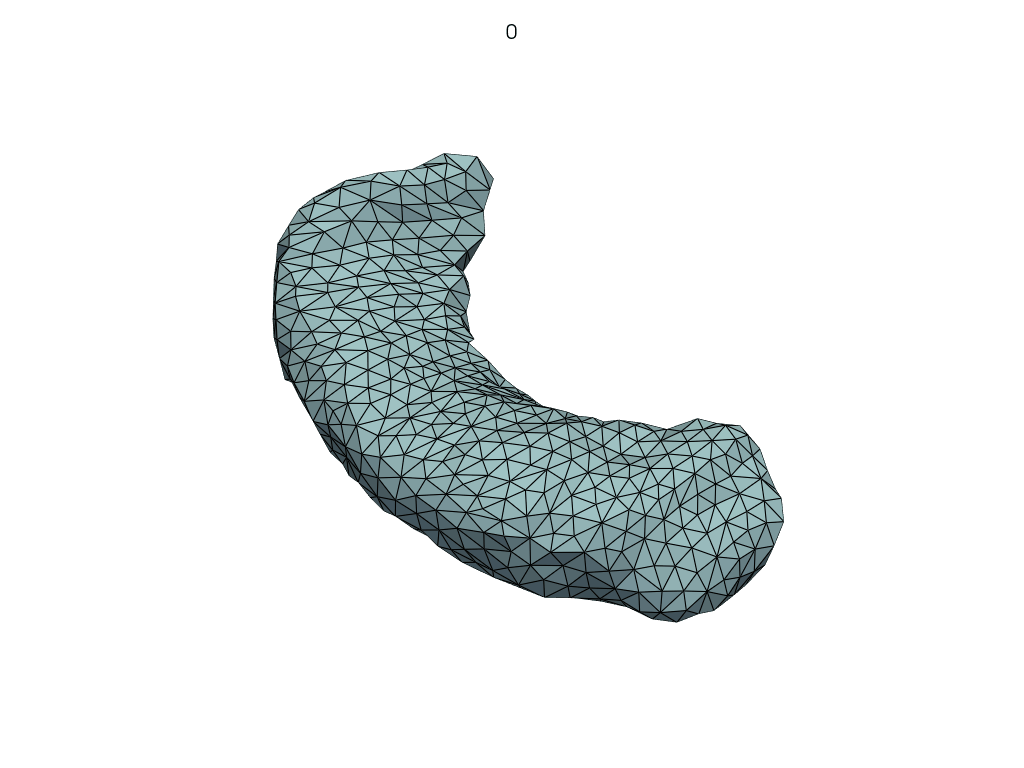

In [16]:
meshes = LoadMeshFlow(
    as_path=False,
    extra_rules=Contains("_GeodesicFlow_"),
)(shoot_dir)


pl = RegisteredMeshesGifPlotter(
    subtitle=lambda x, y: str(x),
    fps=10,
)

pl.add_meshes(meshes)
pl.close()

pl.show()

## Parallel transport (pole ladder)

In [17]:
source = "B"
geod_target = "A"
transp_target = "C"

pole_dir = (
    OUTPUTS_DIR / f"{source}{transp_target}--{source}{geod_target}>{geod_target}_pole"
)

if not pole_dir.exists():
    plddmm.geometry.parallel_transport(
        control_points=plddmm.io.load_cp(
            _register_dir_from_pair(source, geod_target), as_path=True
        ),
        momenta=plddmm.io.load_momenta(
            _register_dir_from_pair(source, geod_target), as_path=True
        ),
        control_points_to_transport=plddmm.io.load_cp(
            _register_dir_from_pair(source, transp_target), as_path=True
        ),
        momenta_to_transport=plddmm.io.load_momenta(
            _register_dir_from_pair(source, transp_target), as_path=True
        ),
        kernel_width=kernel_width,
        output_dir=pole_dir,
        use_pole_ladder=True,
    )

transported_cp = plddmm.io.load_cp(pole_dir, as_path=True)
transported_mom = plddmm.io.load_momenta(pole_dir, as_path=True)

In exponential update, I am not flowing because I don't have any template points to flow
In exponential update, I am not flowing because I don't have any template points to flow


In [18]:
pole_shoot_dir = OUTPUTS_DIR / f"{geod_target}(t{source}{transp_target})_pole"

if not pole_shoot_dir.exists():
    plddmm.geometry.shoot(
        source=dataset[geod_target],
        control_points=transported_cp,
        momenta=transported_mom,
        kernel_width=kernel_width,
        concentration_of_time_points=10,
        kernel_type="torch",
        output_dir=pole_shoot_dir,
        write_adjoint_parameters=False,
    )

[ compute_shooting function ]
Defaulting geodesic t0 to 1.
Defaulting geodesic tmax to 1.
Defaulting geodesic tmin to 0.


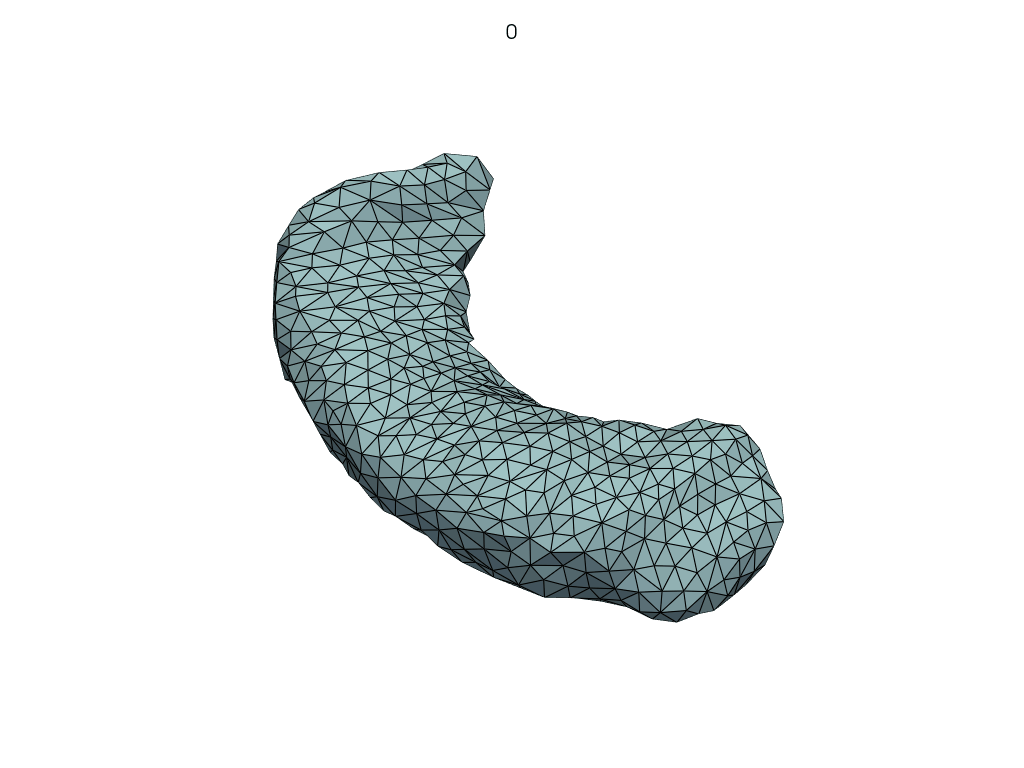

In [19]:
meshes = LoadMeshFlow(
    as_path=False,
    extra_rules=Contains("_GeodesicFlow_"),
)(pole_shoot_dir)


pl = RegisteredMeshesGifPlotter(subtitle=lambda x, y: str(x))

pl.add_meshes(meshes)
pl.close()

pl.show()

## A simpler API

In [20]:
simple_dir = OUTPUTS_DIR / "simple_api"

if not simple_dir.exists():
    plddmm.geometry.parallel_transport_ABC(
        dataset, output_dir=simple_dir, **registration_kwargs
    )

Logger has been set to: DEBUG
>> No initial CP spacing given: using diffeo kernel width of 20.0
OMP_NUM_THREADS was not found in environment variables. An automatic value will be set.
OMP_NUM_THREADS will be set to 10
context has already been set
>> No specified state-file. By default, Deformetrica state will by saved in file: results/transport_abc/simple_api/B->A/deformetrica-state.p.
>> Using a Sobolev gradient for the template data with the ScipyLBFGS estimator memory length being larger than 1. Beware: that can be tricky.
instantiating kernel torch with kernel_width 20.0 and gpu_mode GpuMode.KERNEL. addr: 0x7c76f81d2510
>> Set of 4 control points defined.
>> Momenta initialized to zero, for 1 subjects.
dtype=float32
>> Started estimator: ScipyOptimize

>> Scipy optimization method: L-BFGS-B

------------------------------------- Iteration: 1 -------------------------------------

------------------------------------- Iteration: 20 -------------------------------------
>> Log-likeli